In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from itertools import product
from sklearn.metrics import r2_score
import csv
from vme import VME
from envelope import spline_envelope

In [110]:
# adjusted R-squared
def r2_score_adjusted(y, y_pred, featurecount):
    n = len(y)
    return 1 - (1-r2_score(y, y_pred)) * (n-1)/(n-featurecount-1)

# AIC
def calculate_aic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    return aic

# BIC
def calculate_bic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    bic = n * np.log(sse / n) + k * np.log(n)
    return bic

# импорт временного ряда

In [ ]:
DS = pd.read_csv("DailyDelhiClimateTrain.csv", decimal=',')
DS['date'] = pd.to_datetime(DS['date'])
DS['meantemp'] = pd.to_numeric(DS['meantemp'])
DS.set_index("date", inplace=True)
DS.dropna(inplace=True)
TS = DS['meantemp']
TS

In [ ]:
index = TS.index
index

In [ ]:
k = 4 # количество декомпозиций
f = TS[::].values # значения временного ряда, в дальнейшем - вычеты
u = np.zeros(k, dtype=list) # декомпозиции
low = np.zeros(k, dtype=list) # верхние огибающие
high = np.zeros(k, dtype=list) # нижние огибающие


for i in range(0,k):
    low_envelope, high_envelope = spline_envelope(f,dmin=1,dmax=1)
    low[i] = low_envelope
    high[i] = high_envelope
    # u[i] = (high_envelope + low_envelope)/2
    u[i] = f - (high_envelope + low_envelope)/2
    f = f - u[i]

In [ ]:
fig, axs = plt.subplots(figsize=(12,10), nrows=k+2)

# plt.subplot(2,1,1)
axs[0].set(xlabel = 'date', ylabel='Y')
axs[0].plot(index, TS[::].values)
axs[0].plot(index, low[0])
axs[0].plot(index, high[0])
axs[0].set_title('Original signal')

# plt.subplot(2,1,2)
for i in range(k):
    axs[i+1].plot(index, u[i])
    axs[i+1].set_title(f'IMF {i+1}')
    axs[i+1].set(xlabel = 'date', ylabel='Y')

# plt.subplot(2,2,2)
axs[k+1].plot(index, f)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(figsize=(10,5), nrows=1)


sum_imfs = 0
for i in range(0,k):
    sum_imfs += u[i]

sum_imfs += f
axs.plot(index, TS[::].values)
axs.plot(index, sum_imfs)
plt.title('Residual')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

In [ ]:
Trend = f + u[3]
Season = u[1]+u[2]
Noise = u[0]

# тестовый анализ

In [60]:
#. some sample parameters for VMD
alpha = (500, 1000) # moderate bandwidth constraint
tau = 0 # noise-tolerance (no strict fidelity enforcement)
tol = 1e-6
fs = 10
omega_init = (1, 10)

f = TS[1].reshape((1500,))
sum_imfs = 0
featurecount = 6

criteria = np.zeros(len(alpha)*len(omega_init), dtype=float)
j = 0

In [61]:
list(product(alpha, omega_init))

[(500, 1), (500, 10), (1000, 1), (1000, 10)]

In [62]:
for params_set in list(product(alpha, omega_init)):
    u, u_hat, omega = VME(f, params_set[0], params_set[1], fs, tau, tol)
    criteria[j] = r2_score(f, u.T.real + sum_imfs)
    j += 1

In [63]:
criteria

array([ 0.92248508, -0.08126547,  0.7038971 , -0.08147797])

In [64]:
np.argmax(criteria)

np.int64(0)

In [65]:
np.max(criteria)

np.float64(0.9224850750959839)

In [72]:
list(product(alpha, omega_init))[np.argmax(criteria)][1]

1

Text(0.5, 0, 'X')

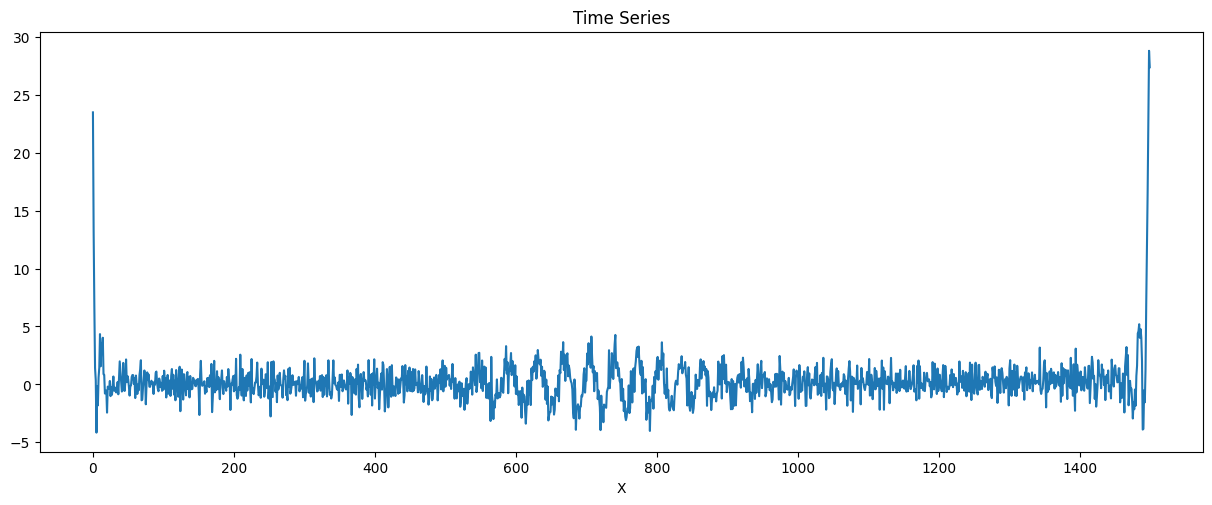

In [27]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], f)
plt.title('Time Series')
plt.xlabel('X')

C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'X')

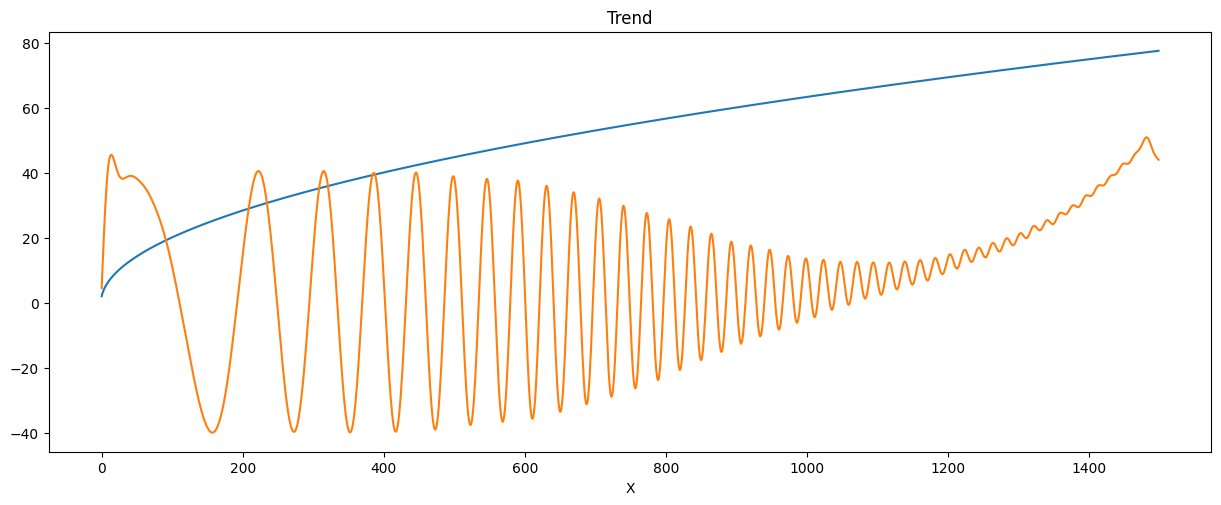

In [28]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], Trend[0])
plt.plot(index[0], u1.T)
plt.title('Trend')
plt.xlabel('X')

In [29]:
Trend[1]

0        0.030150
1        0.030302
2        0.030453
3        0.030606
4        0.030759
          ...    
1495    53.167223
1496    53.433725
1497    53.701563
1498    53.970743
1499    54.241272
Name: Value, Length: 1500, dtype: float64

In [30]:
u.T

array([18.17208935+0.j, 26.23666187+0.j, 32.77041666+0.j, ...,
       62.54522181+0.j, 65.48412422+0.j, 65.30661156+0.j], shape=(1500,))

In [31]:
r2_score(Trend[1], u1.T.real)

-1.8855880403623542

Text(0.5, 0, 'X')

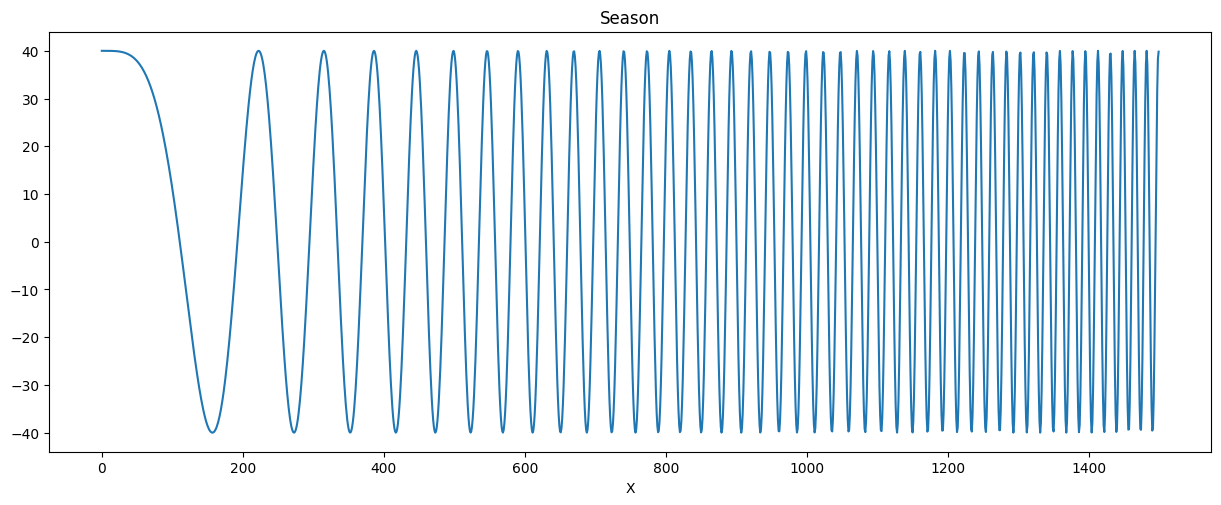

In [32]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], Season)
plt.title('Season')
plt.xlabel('X')

C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\George\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


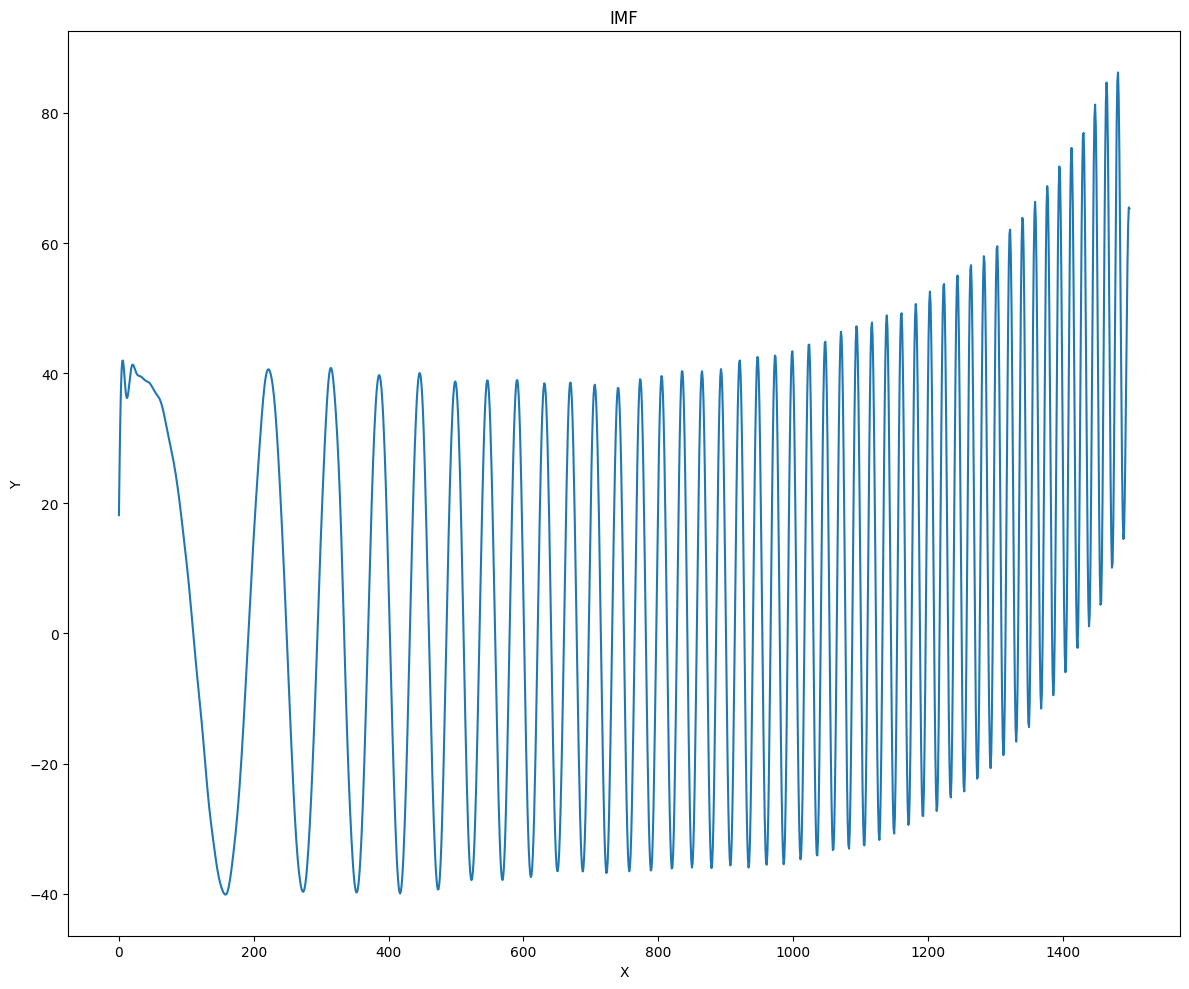

In [33]:
# plt.figure(figsize=(15,12))
# plt.subplot(2,1,1)
# plt.plot(index[0], TS[0])

fig, axs = plt.subplots(figsize=(12,10), nrows=1)

# axs[0].set(xlabel = 'date', ylabel='C')
# plt.subplot(2,2,1)
axs.plot(index[0], u.T)
axs.set_title(f'IMF {i+1}')

plt.title('IMF')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

# Тренд

In [112]:
# набор параметров
alpha = (0, 500, 1000, 5000, 10000, 20000) # moderate bandwidth constraint
omega_init = (1, 501, 1001, 5001, 10001)
fs = 20000
tau = (0, 1, 2, 3) # noise-tolerance (no strict fidelity enforcement)
tol = 1e-6
params_set = list(product(alpha, omega_init, tau))

featurecount = 5

MetricName = "R2"

In [113]:
best_metriks = np.zeros(len(TS), dtype=dict)
best_params = np.zeros((len(TS), 5), dtype=dict)
criteria = np.zeros(len(alpha)*len(omega_init)*len(tau), dtype=float)

f = np.zeros((len(TS), 1500), dtype=list)
k_i = np.zeros(len(TS), dtype=int)

In [114]:
for i in range(len(TS)):
    best_metriks[i] = {"Time Series": f"TS{i+1}", f"{MetricName}": -np.inf}
    
    best_params[i][0] = {"Time Series": f"TS{i+1}", "IMFs" : "1", "Metric": f"{MetricName}", "alpha": 0, "tau": 0, "W init": False, "fs": fs, "tol": 1e-6}
    for j in range(1,5):
        best_params[i][j] = {"Time Series": f"TS{i+1}", "IMFs" : f"1 - {j+1}", "Metric": f"{MetricName}", "alpha": 0, "W init": False, "fs": fs, "tau": 0, "tol": 1e-6}

In [115]:
# для всех лчм
for ts_i in range(len(TS)):
    f[ts_i] = TS[ts_i].reshape((1500,))
    k_i[ts_i] = 0

    best_imfs = 0
    sum_imfs = 0
    isbest_params = True

    while((k_i[ts_i]<5) and isbest_params):
        isbest_params = False
        criteria.fill(0)
        j=0
        # для всех наборов параметров
        for params_i in params_set:
            u, u_hat, omega = VME(f[ts_i], params_i[0], params_i[1], fs, params_i[2], tol)

            criteria[j] = r2_score(Trend[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = np.max(criteria)
        argmax_criteria = np.argmax(criteria)
        if (max_criteria > best_metriks[ts_i][f"{MetricName}"]):
            best_metriks[ts_i][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'1 - {k_i[ts_i]+1}'
            best_params[ts_i][k_i[ts_i]]["alpha"] = params_set[argmax_criteria][0]
            best_params[ts_i][k_i[ts_i]]["W init"] = params_set[argmax_criteria][1]
            best_params[ts_i][k_i[ts_i]]["tau"] = params_set[argmax_criteria][2]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], \
                                fs, best_params[ts_i][k_i[ts_i]]["tau"], tol)
            best_imfs = u.T.real
            isbest_params = True
        
        k_i[ts_i]+=1
        sum_imfs += best_imfs
        if(isbest_params):
            f[ts_i] = f[ts_i] - best_imfs

In [116]:
filename=f".\Output-VME\\Best_Metriks-Trend-{MetricName}-VME.csv"

fields = best_metriks[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_metriks[ts_i]])  # Write data rows

In [117]:
filename=f".\Output-VME\\Parameters-Trend-{MetricName}-VME.csv"

fields = best_params[0][0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        for j in range(5):
            writer.writerows([best_params[ts_i][j]])  # Write data rows

# Сезон

In [118]:
for i in range(len(TS)):
    best_metriks[i] = {"Time Series": f"TS{i+1}", f"{MetricName}": -np.inf}

    best_params[i][0] = {"Time Series": f"TS{i+1}", "IMFs" : f"{k_i[i]}", "Metric": f"{MetricName}", "alpha": 0, "tau": 0, "W init": False, "fs": 0, "tol": 1e-6}
    for j in range(k_i[i],5):
        best_params[i][j] = {"Time Series": f"TS{i+1}", "IMFs" : f"{k_i[i]} - {j+1}", "Metric": f"{MetricName}", "alpha": 0, "W init": False, "fs": 0, "tau": 0, "tol": 1e-6}

In [ ]:
season_k = np.zeros(len(TS), dtype=int)
# для всех лчм
for ts_i in range(len(TS)):
    season_k[ts_i] = k_i[ts_i]
    
    best_imfs = 0
    sum_imfs = 0
    isbest_params = True

    while((k_i[ts_i]<5) and isbest_params):
        isbest_params = False
        criteria.fill(0)
        j=0
        # для всех наборов параметров
        for params_i in params_set:
            u, u_hat, omega = VME(f[ts_i], params_i[0], params_i[1], fs, params_i[2], tol)

            criteria[j] = r2_score(Season[ts_i], u.T.real + sum_imfs)
            j += 1
        
        max_criteria = np.max(criteria)
        argmax_criteria = np.argmax(criteria)
        if (max_criteria > best_metriks[ts_i][f"{MetricName}"]):
            best_metriks[ts_i][f"{MetricName}"] = max_criteria

            best_params[ts_i][k_i[ts_i]]["IMFs"] = f'{season_k[ts_i]} - {k_i[ts_i]+1}'
            best_params[ts_i][k_i[ts_i]]["alpha"] = params_set[argmax_criteria][0]
            best_params[ts_i][k_i[ts_i]]["W init"] = params_set[argmax_criteria][1]
            best_params[ts_i][k_i[ts_i]]["tau"] = params_set[argmax_criteria][2]
            
            u, _, _ = VME(f[ts_i], best_params[ts_i][k_i[ts_i]]["alpha"], best_params[ts_i][k_i[ts_i]]["W init"], \
                                fs, best_params[ts_i][k_i[ts_i]]["tau"], tol)
            best_imfs = u.T.real
            isbest_params = True
        
        k_i[ts_i]+=1
        sum_imfs += best_imfs
        if(isbest_params):
            f[ts_i] = f[ts_i] - best_imfs

In [120]:
filename=f".\Output-VME\\Best_Metriks-Season-{MetricName}-VME.csv"

fields = best_metriks[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_metriks[ts_i]])  # Write data rows

In [121]:
filename=f".\Output-VME\\Parameters-Season-{MetricName}-VME.csv"

fields = best_params[0][0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        for j in range(season_k[ts_i], 5):
            writer.writerows([best_params[ts_i][j]])  # Write data rows

# Шум

In [122]:
for i in range(len(TS)):
    best_metriks[i] = {"Time Series": f"TS{i+1}", f"{MetricName}": -np.inf}

In [123]:
for ts_i in range(len(TS)):
    criteria = r2_score(Noise, f[ts_i])
    if (criteria > best_metriks[ts_i][f"{MetricName}"]):
        best_metriks[ts_i][f"{MetricName}"] = criteria

In [124]:
filename=f".\Output-VME\\Best_Metriks-Noise-{MetricName}-VME.csv"

fields = best_metriks[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_metriks[ts_i]])  # Write data rows

# ШУМ freguency

In [ ]:
for i in range(len(TS)):
    best_metriks[i] = {"Time Series": f"TS{i+1}", f"{MetricName}": -np.inf}

In [126]:
original_noise = np.abs(np.fft.rfft(Noise))

for ts_i in range(len(TS)):
    imf_freg = np.abs(np.fft.rfft(f[ts_i].astype(float)))

    criteria = r2_score(original_noise, imf_freg)
    if (criteria > best_metriks[ts_i][f"{MetricName}"]):
        best_metriks[ts_i][f"{MetricName}"] = criteria

In [127]:
filename=f".\Output-VME\\Best_Metriks-Noise-freg-{MetricName}-VME.csv"

fields = best_metriks[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_metriks[ts_i]])  # Write data rows